<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/1_DAgger/1_DAgger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAgger

![dagger_algorithm](https://github.com/UNIST-LIM-Lab/DRL-course/blob/main/1_DAgger/images/dagger.png?raw=true)

DAgger를 구현하기 위해서는 expert model이 필요한데, DQN으로 학습된 CartPole 모델을 expert model로 사용하도록 하겠습니다.

사용할 pretrained model의 weight는 심층강화학습 수업 Github 레포지토리에 저장되어 있습니다.

Colab에서 Linux 명령어 사용 시 앞에 !를 붙여주어 사용할 수 있습니다.

In [ ]:
!wget https://github.com/UNIST-LIM-Lab/DRL-course/raw/main/1_DAgger/weight/cartpole_expert.pt

다운로드가 완료되었으면 구현에 필요한 라이브러리들을 import 합니다.

In [2]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

jupyter notebook에서 matplotlib을 사용하기 위해 필요한 함수도 import합니다.

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

expert model로 사용할 뉴럴넷 모델입니다. (4 -> 64 -> 128 -> 2)의 구조를 가집니다.

get_action() 함수를 통해 환경에 들어가는 int형의 action을 받을 수 있으며 get_output() 함수를 통해 model의 output을 받을 수 있습니다.


In [4]:
class DQNCartpole(nn.Module):
    def __init__(self, obs_dim, n_actions, device):
        super(DQNCartpole, self).__init__()

        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x

    def get_action(self, obs, epsilon=0):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        if random.random() > epsilon:
            with torch.no_grad():
                q = self.forward(obs)
                action = torch.argmax(q).item()
        else:
            action = random.randrange(self.n_actions)

        return action

    def get_output(self, obs, need_grad=True):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        if need_grad:
            output = self.forward(obs)
        else:
            with torch.no_grad():
                output = self.forward(obs)

        return output.cpu()

Training 하려는 모델(trainee)의 observation과 이 observation에 대한 expert model의 output을 저장하는 Buffer입니다. store()함수를 통해 trainee의 observation, expert의 output을 저장할 수 있고, sample_batch()함수를 통해 batch data를 받아올 수 있습니다.

In [5]:
class Buffer:
    """
    reference from
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    """
    def __init__(self, obs_shape, expert_output_shape, buffer_size):
        buffer_obs_shape = tuple([buffer_size]) + obs_shape
        buffer_expert_output_shape = tuple([buffer_size]) + expert_output_shape
        self.obs_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.expert_output_buf = np.zeros(buffer_expert_output_shape, dtype=np.float32)
        self.pointer, self.size, self.buffer_size = 0, 0, buffer_size

    def store(self, obs, expert_output):
        self.obs_buf[self.pointer] = obs
        self.expert_output_buf[self.pointer] = expert_output
        self.pointer = (self.pointer+1) % self.buffer_size
        self.size = min(self.size+1, self.buffer_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     expert_output=self.expert_output_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def __len__(self):
        return self.size



model과 환경을 받아 한 에피소드를 테스트하는 함수입니다. 에피소드의 리워드를 구하여 반환해줍니다.

In [6]:
def test(model, env):
    test_episode_reward = 0
    obs = env.reset()
    while True:
        action = model.get_action(obs, 0)
        next_obs, rew, done, _ = env.step(action)
        test_episode_reward += rew
        obs = next_obs
        if done:
            break

    return test_episode_reward

Buffer에서 가져온 batch data로 trainee model을 업데이트 하는 함수입니다. Training loss를 반환합니다.

In [7]:
def train(trainee_model, batch, optim, loss):
    obs = batch["obs"].to(device)
    expert_output = batch["expert_output"].to(device)

    trainee_output = trainee_model(obs)
    output = loss(trainee_output, expert_output)

    optim.zero_grad()
    output.backward()
    optim.step()

    return output.item()

matplotlib을 이용해 rewards, losses를 그래프로 보여주는 함수입니다.

In [8]:
def plot(trainee_rewards, expert_rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('reward')
    plt.plot(trainee_rewards, label='trainee')
    plt.plot(expert_rewards, label='expert')
    plt.legend()
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

트레이닝에 필요한 환경, 모델, loss, optimizer 등등을 정의하는 코드입니다.

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
train_env = gym.make("CartPole-v0")
test_env = gym.make("CartPole-v0")

# shape & dimension
obs_shape = train_env.observation_space.shape
obs_dim = obs_shape[0]
n_actions = train_env.action_space.n
expert_output_shape = tuple([n_actions]) # int to Tuple
buffer_size = 1000

# Expert
expert = DQNCartpole(obs_dim=obs_dim, n_actions=n_actions, device=device)
expert.to(device)
expert.load_state_dict(torch.load("cartpole_expert.pt", map_location=device))

# Trainee
trainee = DQNCartpole(obs_dim=obs_dim, n_actions=n_actions, device=device)
trainee.to(device)

# training
loss = nn.MSELoss()
optimizer = optim.SGD(trainee.parameters(), lr=0.0001)

# Buffer
trajectory_buffer = Buffer(obs_shape, expert_output_shape, buffer_size)

# parameters
N = 4000
T = 200
batch_size = 128

# lists for saving results
trainee_rewards = []
expert_rewards = []
losses = []

DAgger를 실행하는 메인 루프입니다. 총 N번의 iteration을 돌면서 trainee model을 이용해 trajectory를 구하여 버퍼에 저장하고, 이 저장한 데이터를 불러와 expert model의 아웃풋과의 결과의 차이를 줄이는 방향으로 학습하게 됩니다.

Iteration이 지남에 따라 trainee 모델이 expert model을 잘 따라 학습하는 것을 그래프를 통해 확인할 수 있습니다.

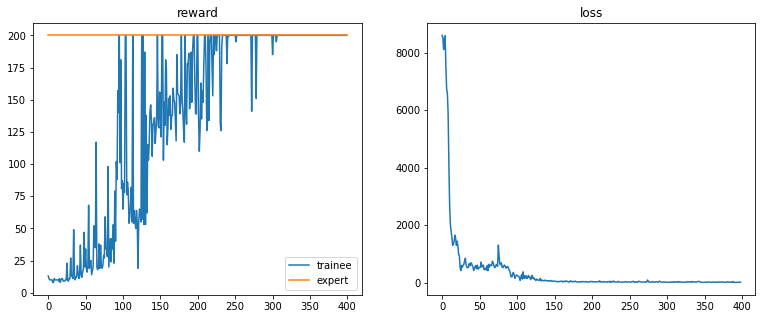

In [10]:
for i in range(N):
    obs = train_env.reset()
    obs_list = [obs]
    # Sample T-step trajectories using pi_i(trainee)
    for t in range(T):
        action = trainee.get_action(obs, epsilon=0)
        obs, _, done, _ = train_env.step(action)
        obs_list.append(obs)
        if done:
            break

    # Get dataset D_i of visited state by pi_i(trainee) and actions give by expert
    for obs in obs_list:
        expert_output = expert.get_output(obs, need_grad=False)
        # Aggregate datasets
        trajectory_buffer.store(obs, expert_output)

    # Train
    if len(trajectory_buffer) >= batch_size:
        sampled_batch = trajectory_buffer.sample_batch(batch_size=batch_size)
        train_loss = train(trainee, sampled_batch, optimizer, loss)
        if i % 10 == 0:
            losses.append(train_loss)

    # Test
    if i % 10 == 0:
        trainee_reward = test(trainee, test_env)
        expert_reward = test(expert, test_env)
        trainee_rewards.append(trainee_reward)
        expert_rewards.append(expert_reward)
        plot(trainee_rewards, expert_rewards, losses)
        # print("Trainee {}, expert {}, step {}".format(trainee_reward, expert_reward, i))
